In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import os

file_path = os.path.dirname(os.getcwd())

def load_data(file_path=file_path+'/u.data'):
    prefer = []
    for line in open(file_path, 'r'):
        (userid, movieid, rating, ts) = line.split('\t')
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
    data = np.array(prefer)
    return data

ratings = load_data()
ratings

array([[1.96e+02, 2.42e+02, 3.00e+00],
       [1.86e+02, 3.02e+02, 3.00e+00],
       [2.20e+01, 3.77e+02, 1.00e+00],
       ...,
       [2.76e+02, 1.09e+03, 1.00e+00],
       [1.30e+01, 2.25e+02, 2.00e+00],
       [1.20e+01, 2.03e+02, 3.00e+00]])

In [3]:
df = pd.DataFrame(ratings, columns=['user', 'item', 'rating'])
df = df.pivot_table(index='user', columns='item', values ='rating')
df_matrix = df.to_numpy()
df

item,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1673.0,1674.0,1675.0,1676.0,1677.0,1678.0,1679.0,1680.0,1681.0,1682.0
user,,,,,,,,,,,,,,,,,,,,,
1.0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940.0,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941.0,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# implicit data conversion
df_matrix[df_matrix>0]=1
df_matrix[df_matrix !=1] = 0
df_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [5]:
# filter the matrix for who have rated at least 10 items and which items have been rated by at least 10 users
row_sums = np.sum(df_matrix,axis=1)
col_sums = np.sum(df_matrix,axis=0)

row_keep = row_sums>=10
col_keep = col_sums>=10

user_movie_data = df_matrix[row_keep][:,col_keep]
user_movie_data

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [6]:
user_movie_data.shape

(943, 1152)

In [7]:
import copy, sys

class BPR:
  def __init__(self,learning_rate = 0.01, features = 20, lbd = 0.01, data = None):
    self.learning_rate = learning_rate
    self.features = features
    
    self.lbd = lbd
    self.data = data

  def fit(self):
    # Initial W, H 생성
    # [0,1) 사이의 uniform distribution 랜덤 생성
    user_feat = np.random.random((self.data.shape[0],self.features))
    item_feat = np.random.random((self.data.shape[1],self.features))

    auc = [0]
    predicted = []
    truevalue = []
    epochs = [0]

    for itr in range(1000001):
      # 랜덤 user 한명 select
      u = np.random.choice(range(self.data.shape[0]))
      u_feat = copy.deepcopy(self.data[u])
      # 그 user가 좋아하는 random item select
      i = np.random.choice(np.where(u_feat==1)[0])
      # 그 user가 좋아하지 않는 (혹은 아직) random item select
      j = np.random.choice(np.where(u_feat==0)[0])

      # user 와 item에 대한 feature vector
      w_u = user_feat[u,:]
      h_i = item_feat[i,:]
      h_j = item_feat[j,:]

      # difference in user's preference 계산
      x_uij = np.dot(w_u,h_i) - np.dot(w_u,h_j)

      # logistic function 적용
      exp = np.exp(-x_uij) / (1 + np.exp(-x_uij))

      # gradient for user feature and update
      grad_wu = exp * (h_i-h_j) + self.lbd * w_u
      user_feat[u,:] = user_feat[u,:] + self.learning_rate * grad_wu
      # gradient for item i feature and update
      grad_hi = exp * (w_u) + self.lbd * h_i
      item_feat[i,:] = item_feat[i,:] + self.learning_rate * grad_hi
      # gradient for item j feature and update      
      grad_hj = exp * (-w_u) + self.lbd * h_j
      item_feat[j,:] = item_feat[j,:] + self.learning_rate * grad_hj

      if(x_uij>0):
        predicted.append(1)
      else:
        predicted.append(0)

      #해당 유저의 movie i와 movie j를 비교해서 보자.
      if(self.data[u][i]==1 and self.data[u][j]==0):
        truevalue.append(1)
      else:
        truevalue.append(0)
        
      if itr >= 100000 and itr%100000==0:
        if not(sum(truevalue)==0 and itr !=0):
          epochs.append(itr)
          auc.append(sum(predicted)/sum(truevalue))
          print(str(itr) + "th auc is : " + str(auc[-1]))

          
      # auc = roc_auc_score(truevalue, predicted)
    


    return epochs, auc, user_feat, item_feat

In [8]:
bpr_model = BPR(0.01,20,0.01,user_movie_data)
epochs, auc, user_feat, item_feat = bpr_model.fit()

100000th auc is : 0.7468525314746852
200000th auc is : 0.7794661026694867
300000th auc is : 0.7922973590088033
400000th auc is : 0.7994255014362464
500000th auc is : 0.804232391535217
600000th auc is : 0.8075153208077986
700000th auc is : 0.8109745557506346
800000th auc is : 0.8140414824481469
900000th auc is : 0.8169379811800209
1000000th auc is : 0.8196951803048197


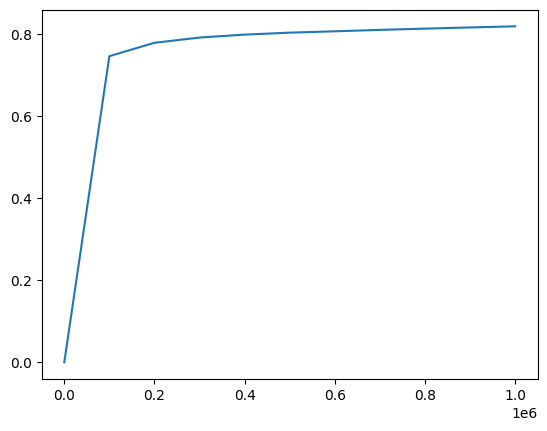

In [9]:
plt.plot(epochs, auc)
plt.show()

In [11]:
user_feat.shape

(943, 20)

In [17]:
score = np.dot(user_feat[0, :], item_feat.T)
score.shape

(1152,)

In [14]:
def get_top_recommendations(user_index, user_feat, item_feat, top_n=5):
    # Compute scores for each item
    scores = np.dot(user_feat[user_index, :], item_feat.T)

    # Get the indices of the top 'n' scores
    top_items_indices = np.argsort(scores)[::-1][:top_n]

    return top_items_indices

In [15]:
get_top_recommendations(0, user_feat, item_feat)

array([ 47, 278, 173, 249, 289], dtype=int64)

In [18]:
class BPR_KNN:
  def __init__(self,learning_rate = 0.01, features = 20, lbd = 0.01, data = None):
    self.learning_rate = learning_rate
    self.features = features
    self.lbd = lbd
    self.data = data
    self.c_item = np.random.random((self.data.shape[1],self.data.shape[1]))


  def fit(self):
    auc = [0]
    predicted = []
    truevalue = []
    epochs = [0]

    for itr in range(1000001):
      u = np.random.choice(range(self.data.shape[0]))
      u_feat = copy.deepcopy(self.data[u])
      i = np.random.choice(np.where(u_feat==1)[0])
      j = np.random.choice(np.where(u_feat==0)[0])

      #C에서 읽도록 u가 ratings에서 (i제외) 평가했던 항목들의 위치를 읽어온다 = 특정 user row 에서 0이 아닌 1인 값의 위치를 읽어옴
      compare_list_temp_i = np.nonzero(self.data[u])[0]
      compare_location_i = compare_list_temp_i[compare_list_temp_i!=i]

      #c_il 들 의 위치를 위해 우선 ith row를 지정하고 나머지는 compare location_i로 위치를 compare 할 item을 찾아준다. 
      #즉 ith item과 ith 를 제외한 다른 item 간의 similarity 계산
      compare_list_i = self.c_item[i][compare_location_i]
      x_ui = np.sum(compare_list_i)

      #j에대해 동일과정 반복. [0]은 (list,공백)인 형태로 나와서
      compare_list_temp_j = np.nonzero(self.data[u])[0]
      compare_location_j = compare_list_temp_j[compare_list_temp_j!=j]

      compare_list_j = self.c_item[j][compare_location_j]
      x_uj = np.sum(compare_list_j)

      x_uij = x_ui-x_uj
      exp = np.exp(-x_uij) / (1 + np.exp(-x_uij))

      grad_ci = exp * 1 + self.lbd * self.c_item[i, compare_location_i]
      grad_cj = exp * (-1) + self.lbd * self.c_item[j, compare_location_j]

      # c update
      self.c_item[i,compare_location_i] = self.c_item[i,compare_location_i] + self.learning_rate * grad_ci
      self.c_item[j,compare_location_j] = self.c_item[j,compare_location_j] + self.learning_rate * grad_cj

      if(x_uij>0):
        predicted.append(1)
      else:
        predicted.append(0)
      
      if(self.data[u][i]==1 and self.data[u][j]==0):
        truevalue.append(1)
      else:
        truevalue.append(0)

      if itr >= 100000 and itr%100000==0:
        if not(sum(truevalue)==0 and itr !=0):
          epochs.append(itr)
          auc.append(sum(predicted)/sum(truevalue))
          print(str(itr) + "th auc is : " + str(auc[-1]))

    return epochs, auc        

  def get_top_recommendations_knn(self, user_index, top_k=5):
    # Compute scores for each item
    scores = np.zeros(self.data.shape[1])
    for item_index in range(self.data.shape[1]):
        compare_list_temp = np.nonzero(self.data[user_index])[0]
        compare_location = compare_list_temp[compare_list_temp != item_index]
        compare_list = self.c_item[item_index][compare_location]
        scores[item_index] = np.sum(compare_list)

    # Get the indices of the top 'k' scores
    top_items_indices = np.argsort(scores)[::-1][:top_k]

    return top_items_indices


100000th auc is : 0.7202127978720213
200000th auc is : 0.7776611116944415
300000th auc is : 0.8074173086089713
400000th auc is : 0.8266679333301666
500000th auc is : 0.8408963182073635
600000th auc is : 0.8519835800273666
700000th auc is : 0.861141626940533
800000th auc is : 0.8687939140076075
900000th auc is : 0.8755168049813278
1000000th auc is : 0.8811781188218811


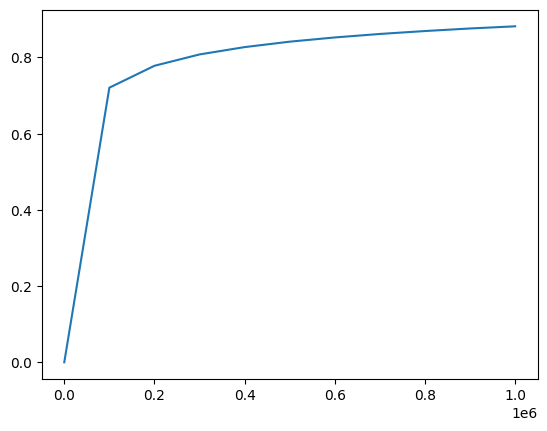

In [20]:
bpr_knn_model = BPR_KNN(0.01,20,0.01,user_movie_data)
epochs, auc = bpr_knn_model.fit()
plt.plot(epochs, auc)
plt.show()

In [22]:
top_recommendations = bpr_knn_model.get_top_recommendations_knn(user_index=0, top_k=5)  # for user at index 0
print("Top 5 recommendations for user 0:", top_recommendations)

Top 5 recommendations for user 0: [173 202 164 175  47]


MF Top 5 recommendations for user 0: [ 47, 278, 173, 249, 289]

KNN Top 5 recommendations for user 0: [173 202 164 175  47]

Two common items!